In [15]:
import pandas as pd

file_path = r"dft_traffic_counts_raw_counts.csv"
df = pd.read_csv(file_path)

df['count_date'] = pd.to_datetime(df['count_date'], errors='coerce')

df['year_quarter'] = df['count_date'].dt.to_period('Q')

vehicle_columns = [
    'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'LGVs',
    'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle', 'HGVs_4_or_more_rigid_axle',
    'HGVs_3_or_4_articulated_axle', 'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle',
    'all_HGVs', 'all_motor_vehicles'
]

unique_location_columns = ['easting', 'northing', 'latitude', 'longitude']

other_columns = [
    'year', 'region_id', 'region_name', 'region_ons_code', 'local_authority_id', 'local_authority_code'
]


agg_funcs = {col: 'sum' for col in vehicle_columns}
agg_funcs.update({col: 'first' for col in other_columns})
agg_funcs.update({col: lambda x: list(set(x)) for col in unique_location_columns})

grouped_df = df.groupby(['local_authority_name', 'year_quarter']).agg(agg_funcs).reset_index()

grouped_df['count_records'] = df.groupby(['local_authority_name', 'year_quarter'])[vehicle_columns[0]].count().values

for col in unique_location_columns:
    grouped_df[col] = grouped_df[col].apply(lambda x: ', '.join(map(str, x)))


output_file_path = r"traffic_counts_quarterly.csv"
grouped_df.to_csv(output_file_path, index=False)

file_path = r"traffic_counts_quarterly.csv"
df = pd.read_csv(file_path)

unique_authorities = df['local_authority_name'].nunique()

print(f"unique local_authority_name number: {unique_authorities}")

<ipython-input-15-943a7d158b73>:4: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


unique local_authority_name number: 213


In [16]:
import pandas as pd

file_path = r"traffic_counts_quarterly.csv"
df = pd.read_csv(file_path)

# Remove duplicates to prevent multiple records for the same city in the same quarter.
df = df.drop_duplicates(subset=['local_authority_name', 'year_quarter'])

# Calculate the time completeness of each city.
completeness = df.groupby('local_authority_name')['year_quarter'].nunique() /92
completeness_df = completeness.reset_index()
completeness_df.columns = ['local_authority_name', 'completeness']

# Define the completeness grouping interval
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.05]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
completeness_df['completeness_group'] = pd.cut(completeness_df['completeness'], bins=bins, labels=labels, right=False)

# Count the number of cities and their proportions in each completeness interval
completeness_stats = completeness_df.groupby('completeness_group')['local_authority_name'].count()
total_cities = len(completeness_df)
completeness_stats_percentage = (completeness_stats / total_cities) * 100


print("Number of cities with different completeness intervals and their proportion in the total cities:")
for group, count in completeness_stats.items():
    percentage = completeness_stats_percentage[group]
    print(f"completeness {group}: number {count}，percentage {percentage:.2f}%")

Number of cities with different completeness intervals and their proportion in the total cities:
completeness 0-20%: number 4，percentage 1.88%
completeness 20-40%: number 2，percentage 0.94%
completeness 40-60%: number 4，percentage 1.88%
completeness 60-80%: number 18，percentage 8.45%
completeness 80-100%: number 185，percentage 86.85%


<ipython-input-16-59c900b85b6e>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completeness_stats = completeness_df.groupby('completeness_group')['local_authority_name'].count()


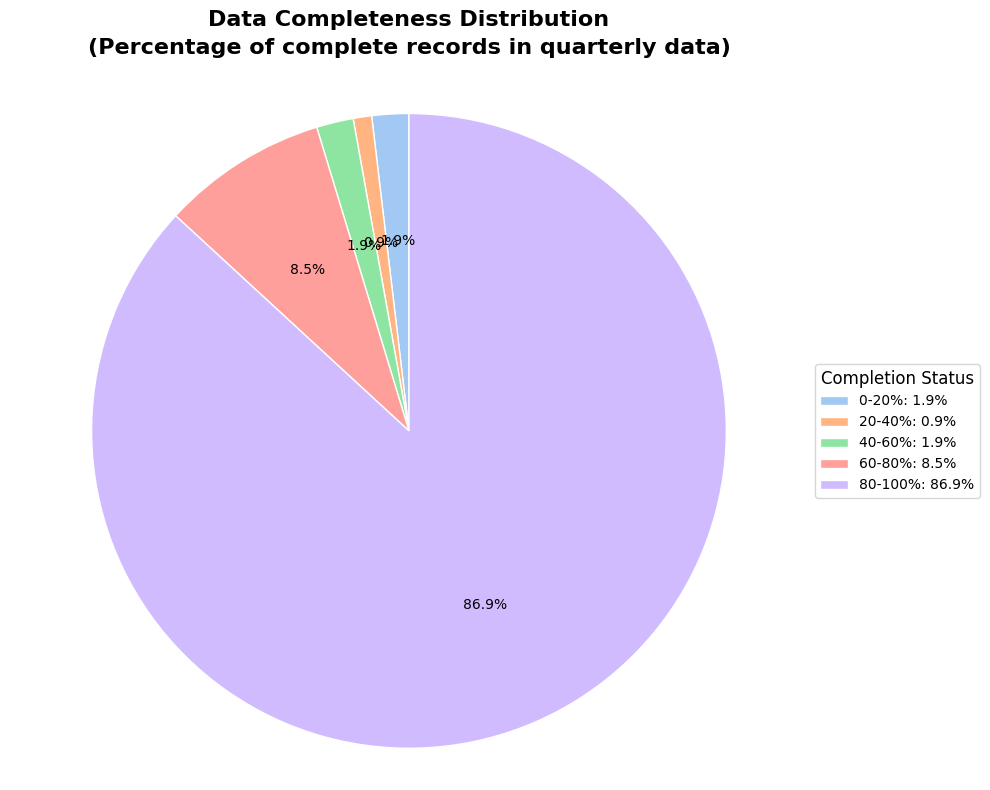

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("pastel")

# Create a pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette("pastel", len(completeness_stats_percentage))
wedges, texts, autotexts = plt.pie(
    completeness_stats_percentage,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10},
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Add a title and adjust the style
plt.title('Data Completeness Distribution\n(Percentage of complete records in quarterly data)',
          fontsize=16, fontweight='bold', pad=20, linespacing=1.5)

legend_labels = [f"{label}: {value:.1f}%" for label, value in
                zip(completeness_stats_percentage.index, completeness_stats_percentage)]

plt.legend(
    wedges,
    legend_labels,
    title="Completion Status",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10,
    title_fontsize=12
)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [18]:
# Calculate completeness as before
completeness = df.groupby('local_authority_name')['year_quarter'].count() / 92
completeness_df = completeness.reset_index()
completeness_df.columns = ['local_authority_name', 'completeness']

# Filter for cities with completeness > 0.8
cities_over_80_percent = completeness_df[completeness_df['completeness'] > 0.8]
print(len(cities_over_80_percent))

# Get the list of local authority names that meet the criteria
local_authorities_to_keep = cities_over_80_percent['local_authority_name'].tolist()
# Filter the original DataFrame
filtered_df = df[df['local_authority_name'].isin(local_authorities_to_keep)]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('traffic_counts_4_0.csv', index=False)


185


In [19]:
import pandas as pd

filtered_df = pd.read_csv('traffic_counts_4_0.csv')

# Create a list of unique quarters
all_quarters = sorted(filtered_df['year_quarter'].unique())

# Create an empty list to store the final DataFrame rows
final_rows = []

# Iterate through each local authority
for local_authority in filtered_df['local_authority_name'].unique():

  local_df = filtered_df[filtered_df['local_authority_name'] == local_authority]

  for quarter in all_quarters:

      if quarter in local_df['year_quarter'].values:
          row = local_df[local_df['year_quarter'] == quarter].iloc[0].to_dict()
          final_rows.append(row)
      else:
          new_row = {'local_authority_name': local_authority, 'year_quarter': quarter}
          for col in filtered_df.columns:
              if col not in new_row:
                  new_row[col] = None
          final_rows.append(new_row)

# Create a new DataFrame from the updated rows
final_df = pd.DataFrame(final_rows)

# Save the completed DataFrame to a new CSV file
final_df.to_csv('traffic_counts_4_completed.csv', index=False)


In [20]:
import pandas as pd
import numpy as np

# Load the dataframe
df = pd.read_csv('traffic_counts_4_completed.csv')

# Define the columns to fill
columns_to_fill = ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle', 'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle', 'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs', 'all_motor_vehicles']

# Iterate through each column
for col in columns_to_fill:
    # Group by local authority and year, then fill missing values with the mean of the group
    df[col] = df.groupby(['local_authority_name', df['year_quarter'].str[:4]])[col].transform(lambda x: x.fillna(np.round(x.mean()).astype(int)))

# save the filled DataFrame to a new CSV
df.to_csv('traffic_counts_4_filled.csv', index=False)
name = df['local_authority_name'].unique()
print(len(name))

<ipython-input-20-8d7e7936dc8a>:13: RuntimeWarning: invalid value encountered in cast
  df[col] = df.groupby(['local_authority_name', df['year_quarter'].str[:4]])[col].transform(lambda x: x.fillna(np.round(x.mean()).astype(int)))
<ipython-input-20-8d7e7936dc8a>:13: RuntimeWarning: invalid value encountered in cast
  df[col] = df.groupby(['local_authority_name', df['year_quarter'].str[:4]])[col].transform(lambda x: x.fillna(np.round(x.mean()).astype(int)))
<ipython-input-20-8d7e7936dc8a>:13: RuntimeWarning: invalid value encountered in cast
  df[col] = df.groupby(['local_authority_name', df['year_quarter'].str[:4]])[col].transform(lambda x: x.fillna(np.round(x.mean()).astype(int)))
<ipython-input-20-8d7e7936dc8a>:13: RuntimeWarning: invalid value encountered in cast
  df[col] = df.groupby(['local_authority_name', df['year_quarter'].str[:4]])[col].transform(lambda x: x.fillna(np.round(x.mean()).astype(int)))
<ipython-input-20-8d7e7936dc8a>:13: RuntimeWarning: invalid value encountered in

185


In [21]:
import pandas as pd

try:
  df1 = pd.read_csv('GDP_ITL3_LDA(raw).csv')
  df2 = pd.read_csv('traffic_counts_4_filled.csv')

except FileNotFoundError:
  print("One or both CSV files not found. Please make sure they are in the same directory as the script.")
  exit()

# Search for common names
common_names = set(df1['Region Name']).intersection(set(df2['local_authority_name']))

# Filter df2 to retain only the matching local_authority_name.
filtered_df = df2[df2['local_authority_name'].isin(common_names)]
filtered_df.to_csv('final_matched_quarter_traffic.csv', index=False)

print(f"Filtered data saved to 'final_matched_quarter_traffic.csv'. Rows retained: {len(filtered_df)}")
print(len(common_names))

Filtered data saved to 'final_matched_quarter_traffic.csv'. Rows retained: 6365
67


This is followed by an interactive map of the areas where traffic data matches economic data.

In [22]:
!pip install geopandas
import geopandas as gpd
import folium

only_in_traffic = set(df2['local_authority_name']) - common_names
print(f"Only the number of cities in the traffic data: {len(only_in_traffic)}")

import os

file_path = "Local_Authority_Districts.geojson"
if not os.path.exists(file_path):
  !wget https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/administrative/eng/lad.json -O Local_Authority_Districts.geojson
  print(f"Downloaded {file_path}")

# Continue with reading the file:
uk_map = gpd.read_file(file_path)

# Create a Folium map
m = folium.Map(location=[55, -3], zoom_start=6)

# Define traffic_cities (assuming it contains all cities from traffic data)
traffic_cities = df2['local_authority_name'].unique()

# Add all traffic data cities (gray)
for city in traffic_cities:
    city_data = uk_map[uk_map["LAD13NM"] == city]
    if not city_data.empty:
        folium.GeoJson(city_data, style_function=lambda x: {"fillColor": "gray"}).add_to(m)

# Add Transportation + Economy Co-city (Blue)
for city in common_names:
    city_data = uk_map[uk_map["LAD13NM"] == city]
    if not city_data.empty:
        folium.GeoJson(city_data, style_function=lambda x: {"fillColor": "blue"}).add_to(m)

# Add cities that are only in the traffic data (red).
for city in only_in_traffic:
    city_data = uk_map[uk_map["LAD13NM"] == city]
    if not city_data.empty:
        folium.GeoJson(city_data, style_function=lambda x: {"fillColor": "red"}).add_to(m)

# Display map
m.save("filtered_cities_map.html")
print("The map has been saved as filtered_cities_map.html. Please open it in a browser to view.")
from IPython.core.display import display, HTML
display(HTML("filtered_cities_map.html"))

Only the number of cities in the traffic data: 118
The map has been saved as filtered_cities_map.html. Please open it in a browser to view.
